In [ ]:
from google.colab import drive
drive.mount('/content/drive')

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


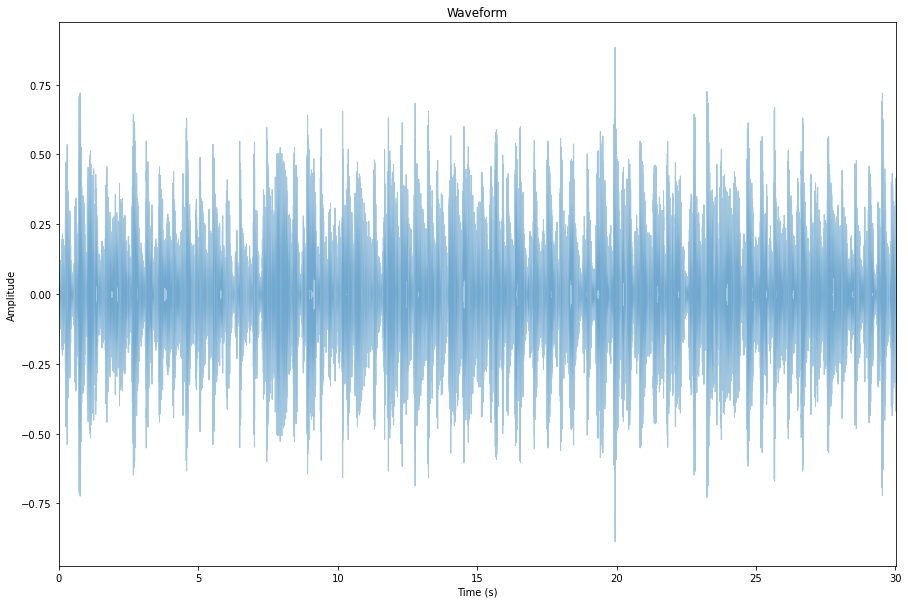

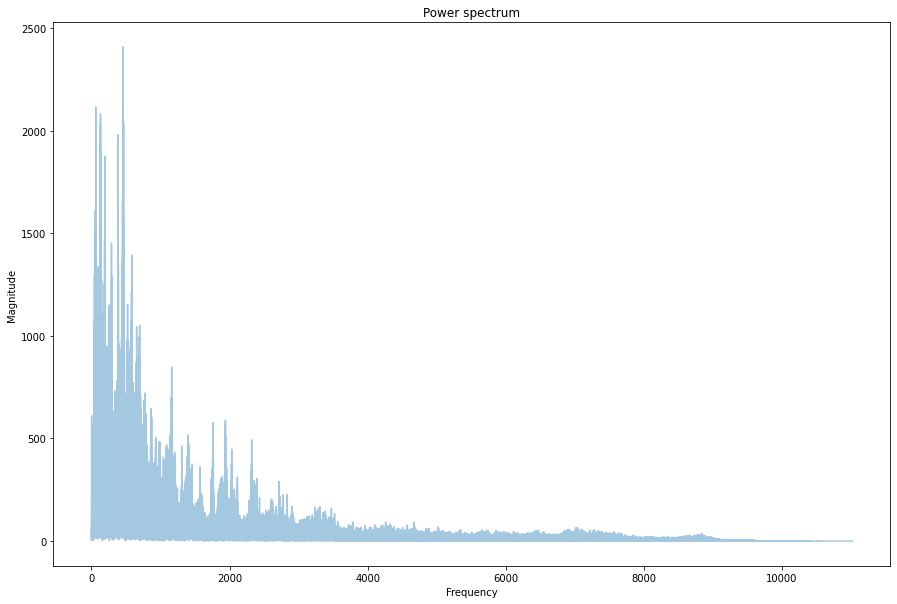

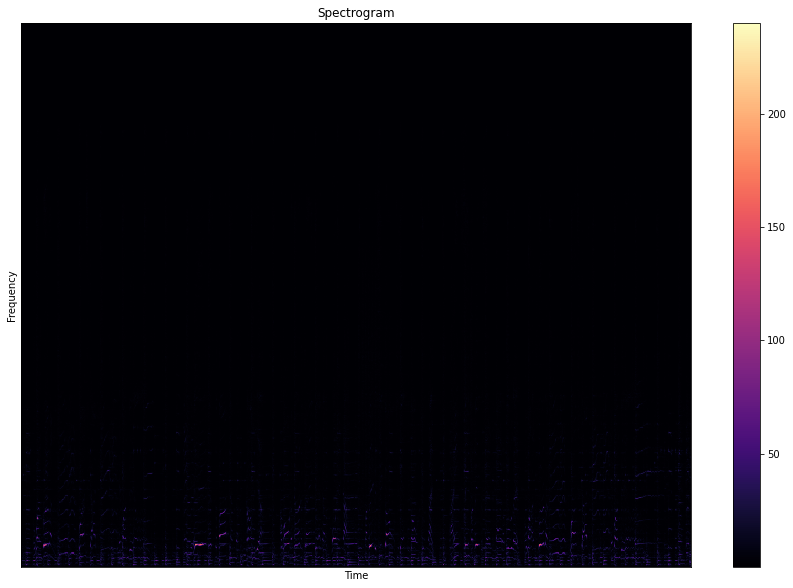

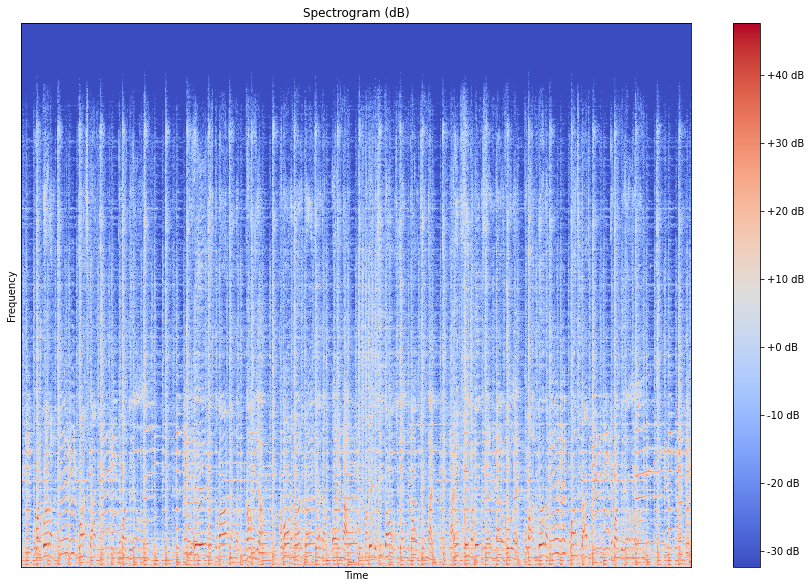

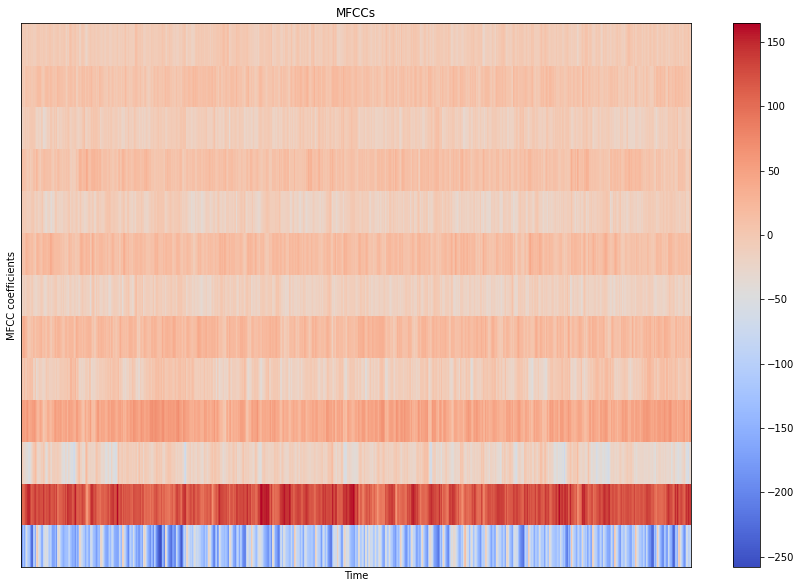

In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)

file = "/content/drive/MyDrive/blues.00000.wav"

# load audio file with Librosa
signal, sample_rate = librosa.load(file, sr=22050)

# WAVEFORM
# display waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")


# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")


# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")


# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()


In [ ]:
import json
import os
import math
import librosa 
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/genres_original"
JSON_PATH = "/content/drive/MyDrive/data_100.json"


In [ ]:

def load_data(json_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(json_path) as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    print(X.shape)
    y = np.array(data["labels"])
    print(y.shape)
    return X, y

In [ ]:
def prepare_datasets(test_size, validation_size):
  

   # load data
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    print(X_train.shape)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test
    #return X_train, X_test, y_train, y_test, X

In [ ]:
def build_model(input_shape):
    
    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(512, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(512))
    #model.add(regularizers.L2(l2=0.01))
    # dense layer
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.4))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model



In [ ]:
    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.3, 0.2)
    #X_train, X_test, y_train, y_test, X = prepare_datasets(0.3, 0.2)
    #print("X",X.shape)
    # create network
    #input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    input_shape = (X_train.shape[1],X_train.shape[2])
    model = build_model(input_shape)

(9900, 117, 13)
(9900,)
(6930, 117, 13)


In [ ]:
#StopCallback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                #patience=10,
                                                #restore_best_weights=True,
                                                #verbose=1)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

    # train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=25)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 117, 512)          1077248   
_________________________________________________________________
lstm_9 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [ ]:
def plot_history(history):
  

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


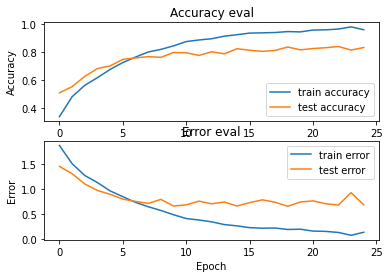

93/93 - 65s - loss: 0.7622 - accuracy: 0.8246

Test accuracy: 0.824579119682312


In [ ]:
    # plot accuracy/error for training and validation
    plot_history(history)
 
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)